In [188]:
from typing import Dict, List, Tuple, Union
from skimage import exposure, img_as_ubyte
import rasterio
import pathlib
import re
import cv2
import numpy as np
from matplotlib import pyplot as plt
import matplotlib.gridspec as gridspec

In [189]:
def load_landsat_image(
    img_folder: Union[str, None],
    bands: Union[List[str], None]
) -> Dict:
    """
    Take a folder path and return a dict with the raw vectors extracted from the Earth Engine.
    """
    # Dictionary to save the image.
    images_dict = {}

    if img_folder:
        # Use the provided path.
        path = pathlib.Path(img_folder)
    else:
        # Get the path to retrieve.
        path = pathlib.Path(__file__).parent

    # Get the list of all files.
    files = [f.name for f in path.glob('**/*.tif')]
    # Parse all of filenames to get the unique ones.
    files = set([re.search('_[0-9](.*)[0-9]_', x).group() for x in files])
    # Dict of images to return.
    images_dict = {}

    # Iterate over the files.
    for pat in files:
        image = {}
        # Iterate over the bands.
        for band in bands:
            file = next(path.glob(f'*{pat}{band}.tif'))
            print(f'Opening file {file}')
            ds = rasterio.open(file)
            image.update({band: ds.read(1)})
        # Update the main dict.
        images_dict.update(
            {pat.replace('_','') : image}
        )

    return images_dict

def display_rgb(
    img: Union[Dict, None], 
    alpha=1., 
    figsize=(10, 10)
    ) -> None:
    rgb = np.stack(
        [img['B4'], img['B3'], img['B2']],
        axis=-1
    )
    rgb = rgb/rgb.max() * alpha
    plt.figure(figsize=figsize)
    plt.imshow(rgb)
    
def convert_to_eight_bits(
    img: Union[Dict, None]
) -> np.array:
    """
    To reescale image to 8 bits.
    """
    img_stack = np.stack(
        [img['B4'], img['B3'], img['B2']]
        , axis=-1)

    scaled_img = img_as_ubyte(
        exposure.rescale_intensity(img_stack)
    )
    
    return scaled_img

def convert_to_hsv(rgb):
    hsv = cv2.cvtColor(rgb, cv2.COLOR_BGR2HSV_FULL)
    return hsv

In [190]:
IMGS_PATH = '/home/mauricio/code/Plant-Growth-Cycle-based-on-geospatial-data/ClimateData_NIR_RGB/'
band_labels = ["B4", "B3", "B2"]
images = load_landsat_image(IMGS_PATH, band_labels)
img_keys = list(images.keys())

Opening file /home/mauricio/code/Plant-Growth-Cycle-based-on-geospatial-data/ClimateData_NIR_RGB/S-HARMONIZED_20210814T165901_20210814T170626_T15TVG_14Aug2021_B4.tif
Opening file /home/mauricio/code/Plant-Growth-Cycle-based-on-geospatial-data/ClimateData_NIR_RGB/S-HARMONIZED_20210814T165901_20210814T170626_T15TVG_14Aug2021_B3.tif
Opening file /home/mauricio/code/Plant-Growth-Cycle-based-on-geospatial-data/ClimateData_NIR_RGB/S-HARMONIZED_20210814T165901_20210814T170626_T15TVG_14Aug2021_B2.tif
Opening file /home/mauricio/code/Plant-Growth-Cycle-based-on-geospatial-data/ClimateData_NIR_RGB/S-HARMONIZED_20210812T170849_20210812T171908_T15TVG_12Aug2021_B4.tif
Opening file /home/mauricio/code/Plant-Growth-Cycle-based-on-geospatial-data/ClimateData_NIR_RGB/S-HARMONIZED_20210812T170849_20210812T171908_T15TVG_12Aug2021_B3.tif
Opening file /home/mauricio/code/Plant-Growth-Cycle-based-on-geospatial-data/ClimateData_NIR_RGB/S-HARMONIZED_20210812T170849_20210812T171908_T15TVG_12Aug2021_B2.tif
Open

In [241]:
#Edge detection

def edge_detection_preprocessing(image_data, canny_parameter1=100, canny_parameter2=100):

    image = convert_to_eight_bits(image_data)

    hsv_filter = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    grayscale_filter = cv2.cvtColor(cv2.cvtColor(cv2.cvtColor(image, cv2.COLOR_BGR2RGB), cv2.COLOR_BGR2HSV_FULL), cv2.COLOR_RGB2GRAY)
    gaussian_filter = cv2.GaussianBlur(hsv_filter, (5,5), 0)
    grayscale_gaussian_filter = cv2.GaussianBlur(grayscale_filter, (5,5), 0)

    grayscale_canny = cv2.Canny(grayscale_filter, canny_parameter1, canny_parameter2)
    gaussian_canny = cv2.Canny(gaussian_filter, canny_parameter1, canny_parameter2)
    grayscale_gaussian_canny = cv2.Canny(grayscale_gaussian_filter, canny_parameter1, canny_parameter2)

    return image, hsv_filter, grayscale_filter, gaussian_filter, grayscale_gaussian_filter, grayscale_canny, gaussian_canny, grayscale_gaussian_canny


def visualize_edge_detection(image, hsv_filter, grayscale_filter, gaussian_filter, grayscale_gaussian_filter, grayscale_canny, gaussian_canny, grayscale_gaussian_canny):
    fig, axes = plt.subplots(4, 2, figsize=(7, 10))

    fig.subplots_adjust()
    fig.tight_layout()
    axes = axes.ravel()

    axes[0].imshow(image)
    axes[0].set_title('Original Image'), axes[0].set_xticks([]), axes[0].set_yticks([])
    axes[1].imshow(hsv_filter)
    axes[1].set_title('HSV Filter'), axes[1].set_xticks([]), axes[1].set_yticks([])
    axes[2].imshow(gaussian_filter)
    axes[2].set_title("Gaussian Filter"), axes[2].set_xticks([]), axes[2].set_yticks([])
    axes[3].imshow(gaussian_canny)
    axes[3].set_title("Canny (Gaussian)"), axes[3].set_xticks([]), axes[3].set_yticks([])
    axes[4].imshow(grayscale_filter, cmap = "gray")
    axes[4].set_title("Grayscale"), axes[4].set_xticks([]), axes[4].set_yticks([])
    axes[5].imshow(grayscale_canny, cmap = "gray")
    axes[5].set_title("Canny (Grayscale)"), axes[5].set_xticks([]), axes[5].set_yticks([])
    axes[6].imshow(grayscale_gaussian_filter, cmap = "gray")
    axes[6].set_title("Gaussian + Grayscale"), axes[6].set_xticks([]), axes[6].set_yticks([])
    axes[7].imshow(grayscale_gaussian_canny, cmap = "gray")
    axes[7].set_title("Canny (Gaussian + Grayscale)"), axes[7].set_xticks([]), axes[7].set_yticks([])
    plt.show()

def visualize_filter_edges(filters, edges, title):
    fig, axes = plt.subplots(1, 2, figsize=(15, 10))
    fig.tight_layout()
    fig.suptitle(title)
    fig.subplots_adjust()
    axes = axes.ravel()


    axes[0].imshow(filters)
    axes[0].set_title('Original Filter'), axes[0].set_xticks([]), axes[0].set_yticks([])
    axes[1].imshow(edges)
    axes[1].set_title('Edges'), axes[1].set_xticks([]), axes[1].set_yticks([])

    plt.show()


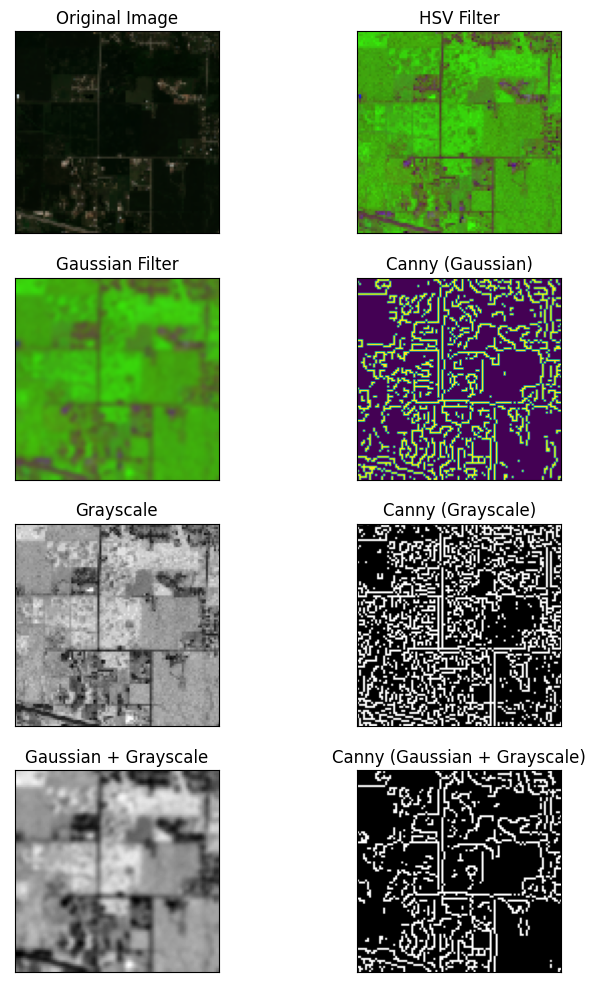

In [238]:
image, hsv_filter, grayscale_filter, gaussian_filter, grayscale_gaussian_filter, grayscale_canny, gaussian_canny, grayscale_gaussian_canny = edge_detection_preprocessing(images[img_keys[0]], 50, 50)

visualize_edge_detection(image, hsv_filter, grayscale_filter, gaussian_filter, grayscale_gaussian_filter, grayscale_canny, gaussian_canny, grayscale_gaussian_canny)

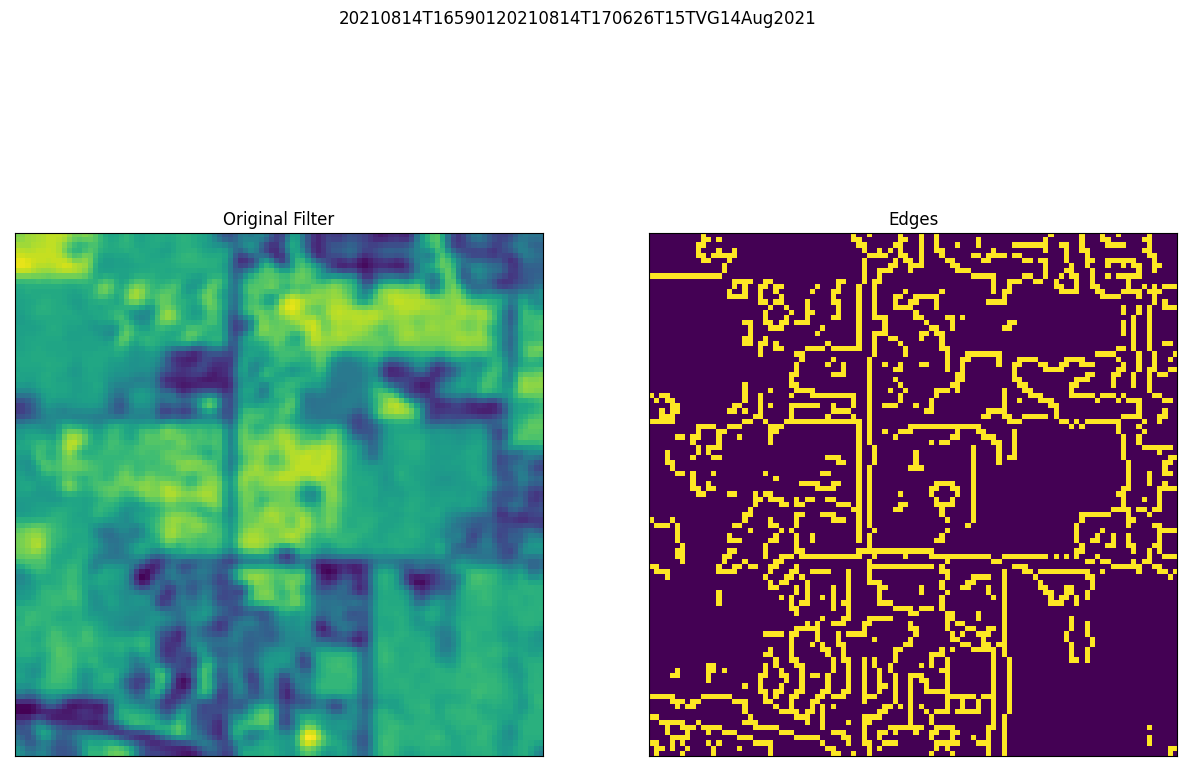

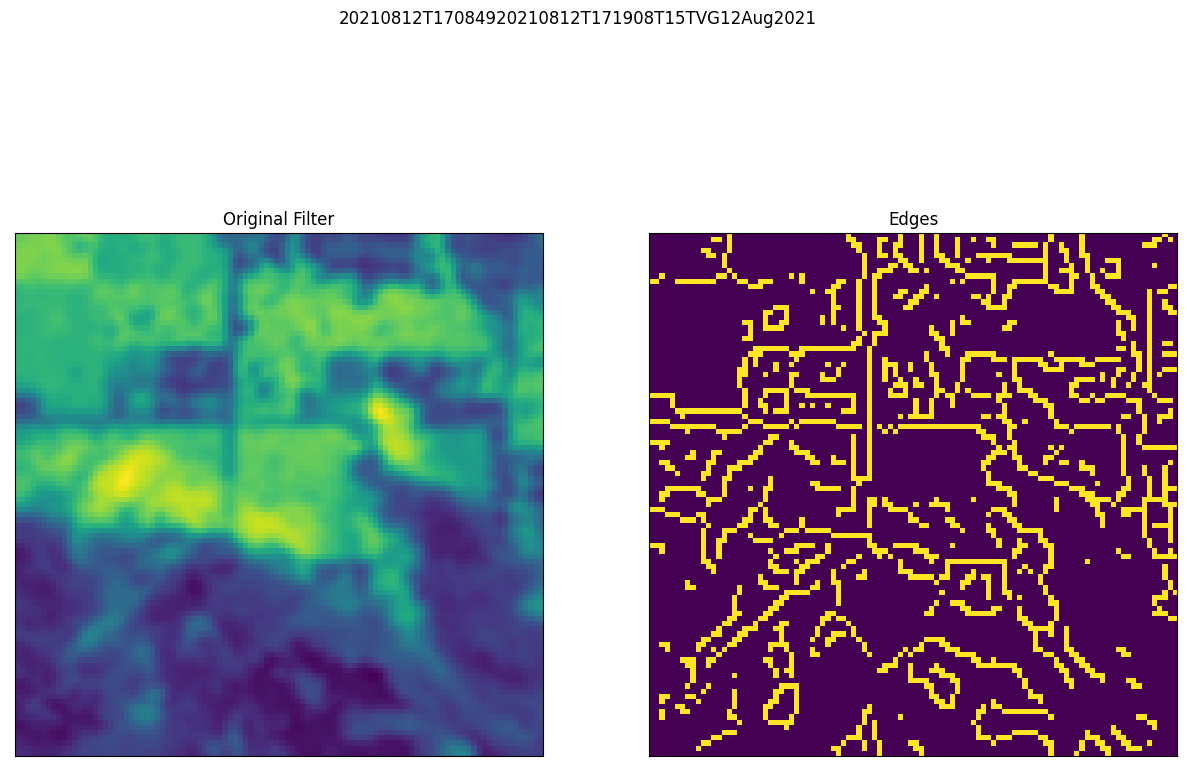

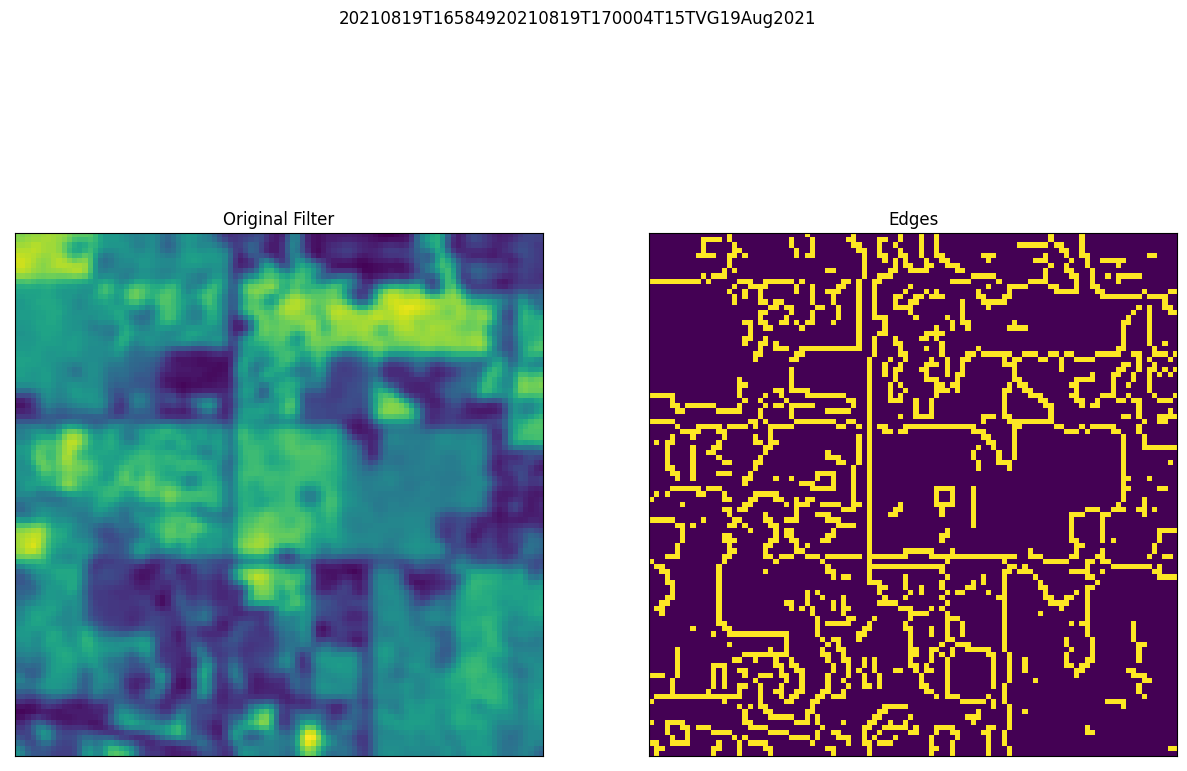

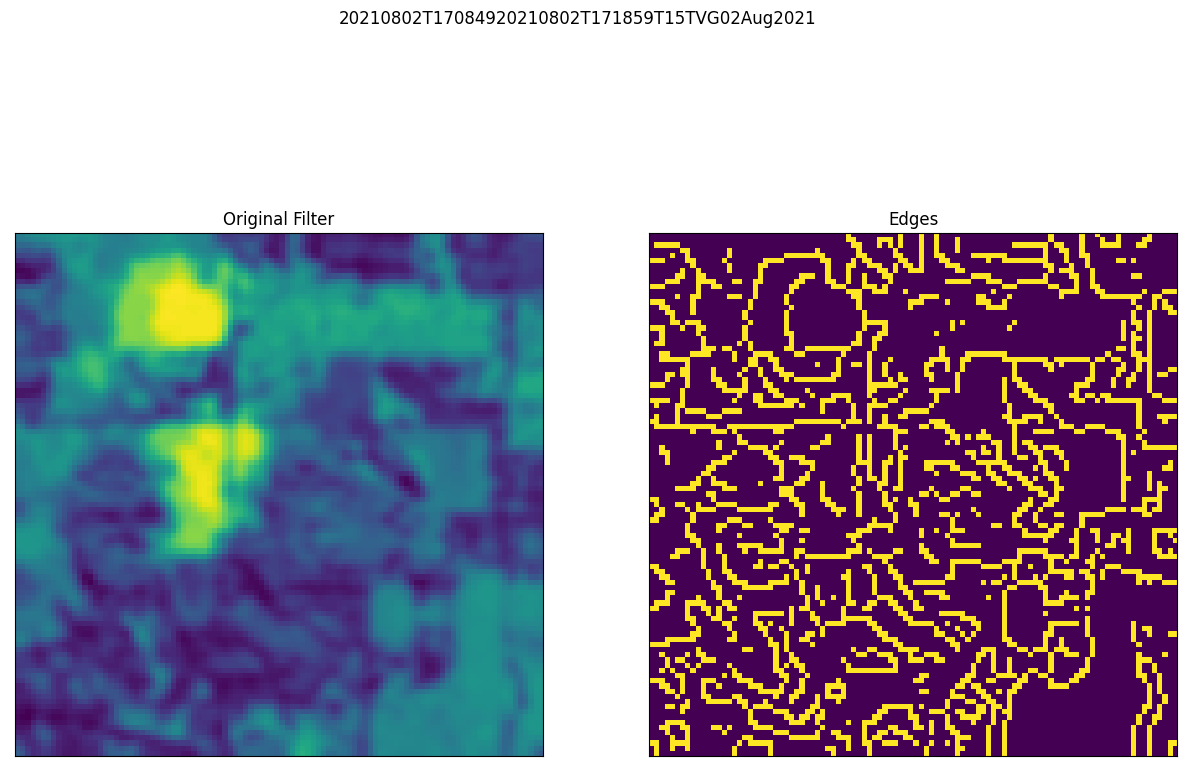

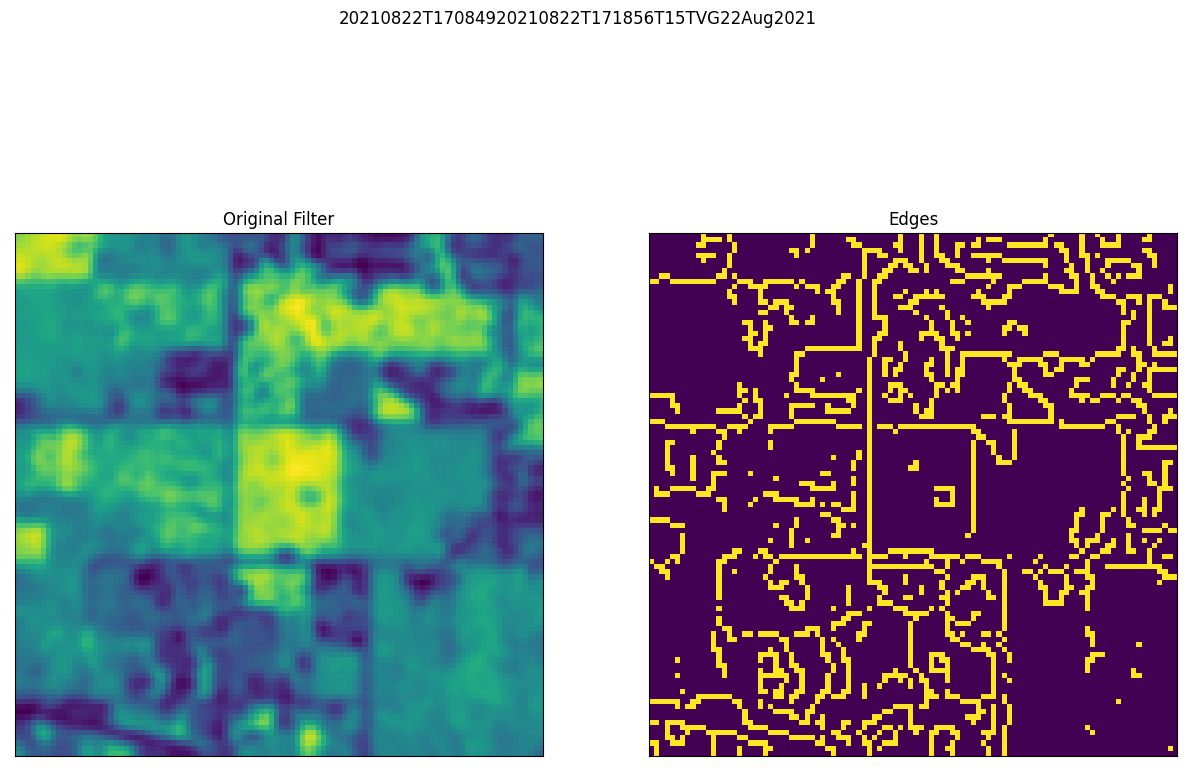

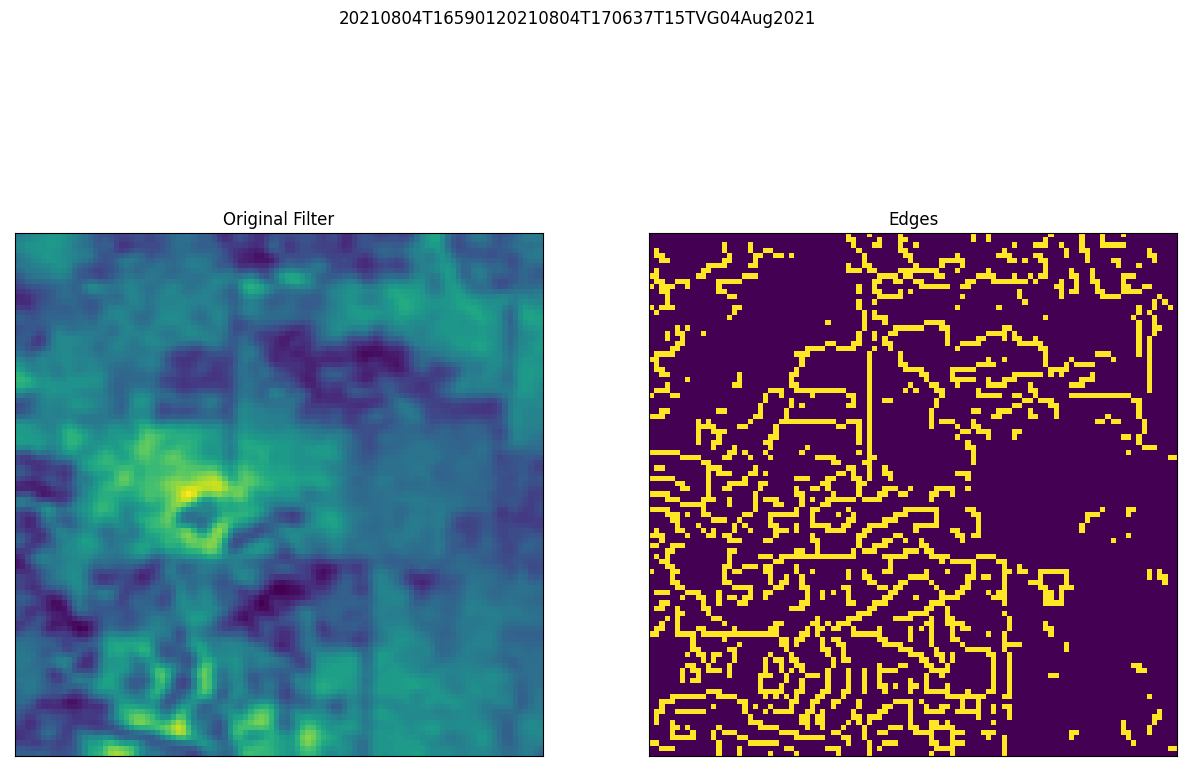

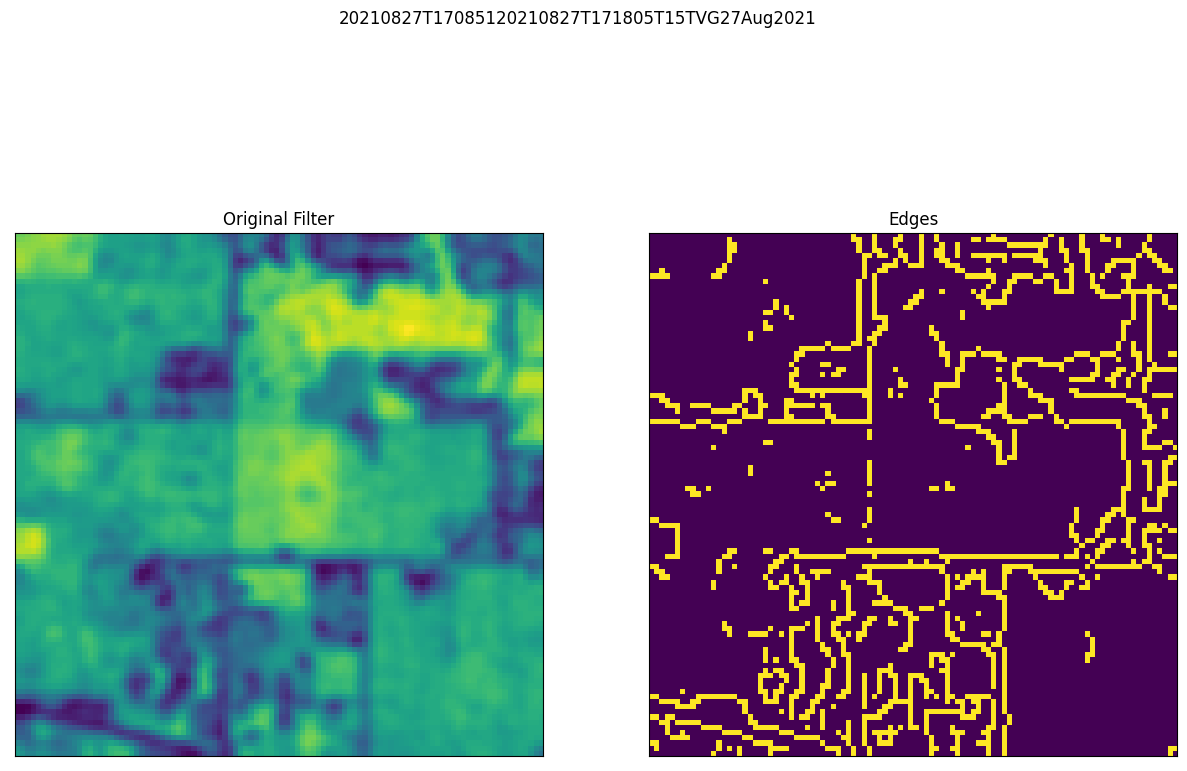

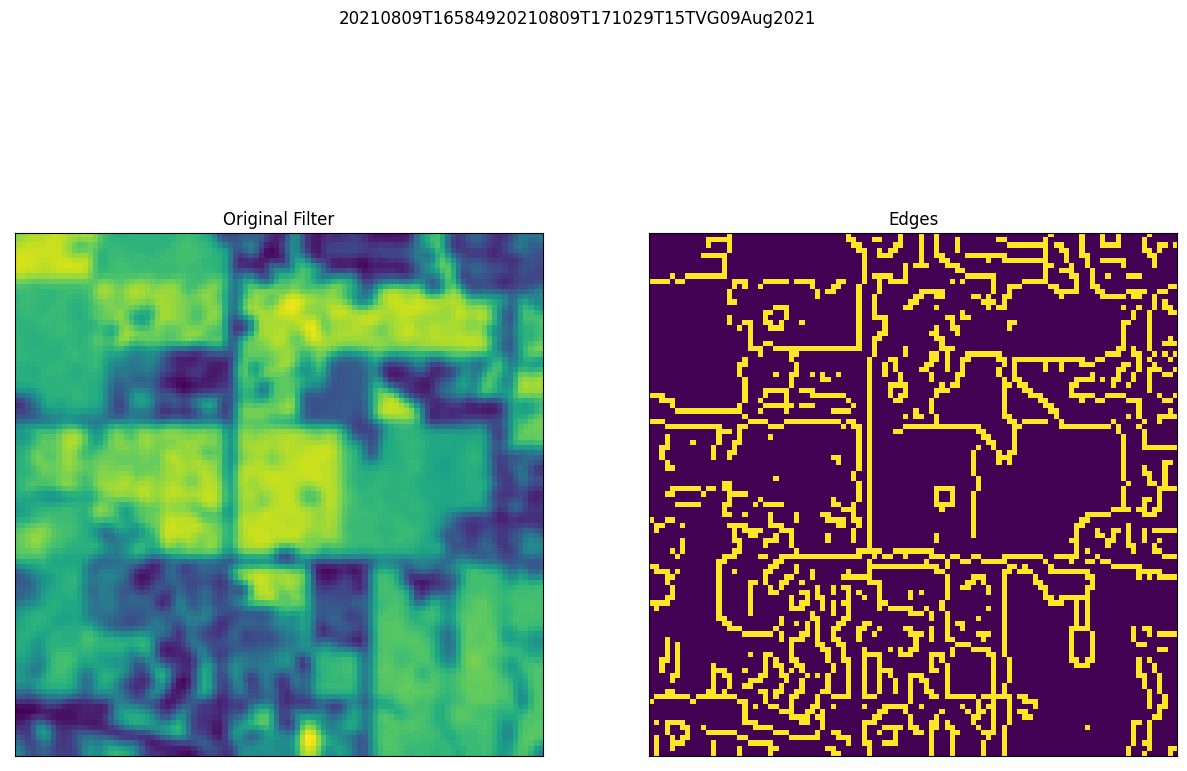

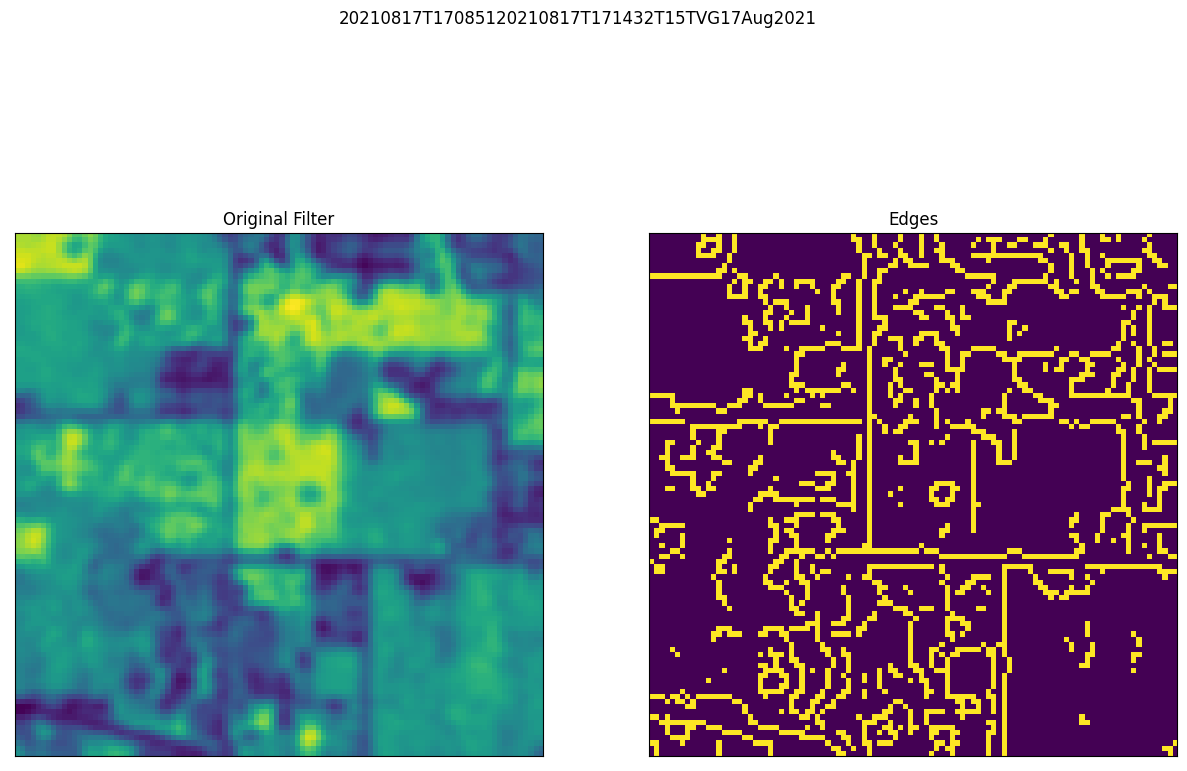

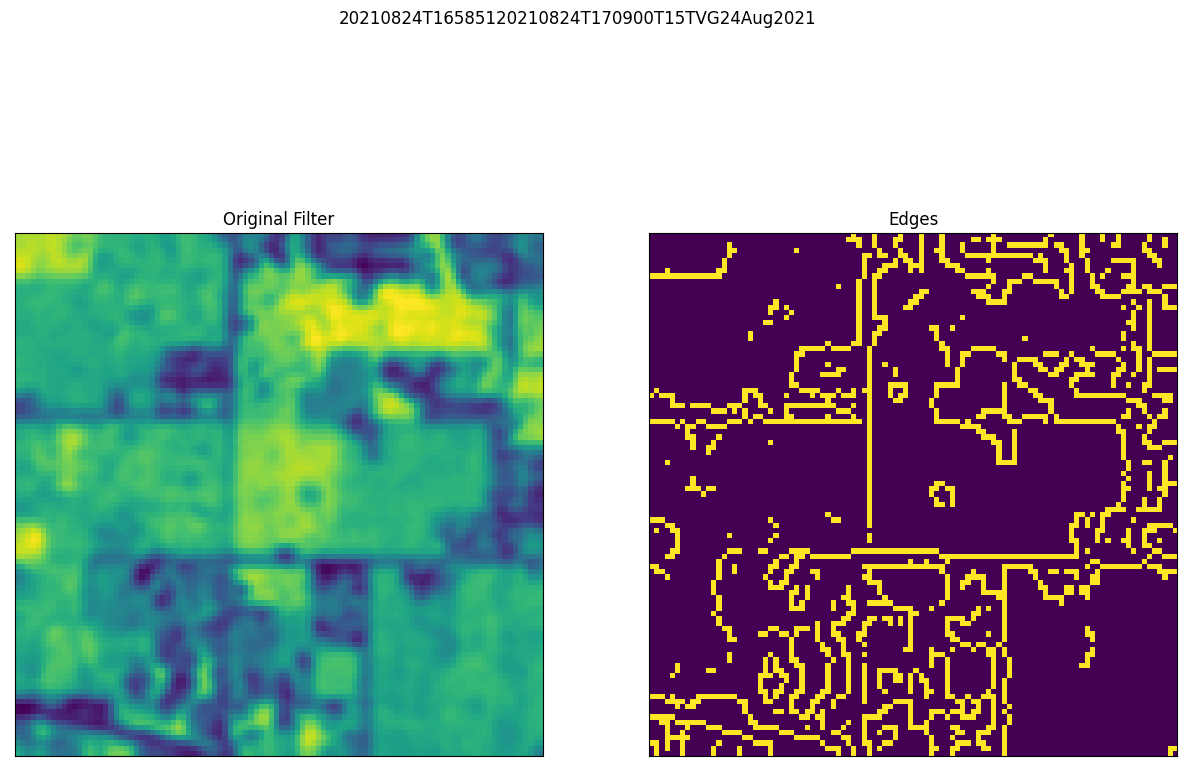

In [243]:
for key in img_keys:
    img = images[key]
    image, hsv_filter, grayscale_filter, gaussian_filter, grayscale_gaussian_filter, grayscale_canny, gaussian_canny, grayscale_gaussian_canny = edge_detection_preprocessing(img, 50, 50)
    visualize_filter_edges(grayscale_gaussian_filter, grayscale_gaussian_canny, key)

In [240]:
import cv2
import sys
import os

nRows = int(sys.argv[3])
# Number of columns
mCols = int(sys.argv[3])

# Reading image
img = cv2.imread(sys.argv[1])
#print img

#cv2.imshow('image',img)

# Dimensions of the image
sizeX = img.shape[1]
sizeY = img.shape[0]

print(img.shape)


for i in range(0,nRows):
    for j in range(0, mCols):
        roi = img[i*sizeY/nRows:i*sizeY/nRows + sizeY/nRows ,j*sizeX/mCols:j*sizeX/mCols + sizeX/mCols]
        cv2.imshow('rois'+str(i)+str(j), roi)

ValueError: invalid literal for int() with base 10: '--control=9031'